In [2]:
## plot
%matplotlib inline
import matplotlib.pyplot as plt

## operations
import numpy as np
from scipy.io import loadmat
from scipy import signal
from scipy.signal import butter, lfilter, hilbert, chirp

from scipy import stats 

## time_frequency
from mne.time_frequency import tfr_array_multitaper, psd_array_multitaper
from mne.stats import permutation_cluster_1samp_test, permutation_cluster_test


## pac
# from pactools import Comodulogram, REFERENCES
# from pactools import simulate_pac

import pandas as pd

from statsmodels.formula.api import ols, mixedlm
import statsmodels.api as sm

## Saving data dictionaries
import pickle  

In [4]:
## Load study related info
with open('../Results/study_info.pickle', 'rb') as handle:
    study_info = pickle.load(handle,encoding='latin1')
    

density        = study_info['density'] 
speed          = study_info['speed'] 
dd             = study_info['dd'] ## Number of sensory cues (density)
dur            = study_info['dur'] ## Trial duration (sec)
K_i_idx        = study_info['K_i_idx']
K_i            = study_info['K_i']
uni            = study_info['uni']
t_dur          = study_info['t_dur']
t_dd           = study_info['t_dd']
sessions       = study_info['sessions'] 
ttl_idx        = study_info['ttl_idx']
hpc_electrodes = study_info['hpc_electrodes']
fs = study_info['fs']



## Load trial markers for each session
with open('../Results/trials_markers.pickle', 'rb') as handle:
    trials_markers = pickle.load(handle,encoding='latin1')

In [10]:
study_info

{'K_i_idx': (array([0, 1, 2, 0, 1, 0, 2, 1, 2]),
  array([0, 0, 0, 1, 1, 2, 1, 2, 2])),
 't_dur': array([19.88950276, 26.66666667, 32.72727273]),
 'sessions': ['Eugeni_s2',
  'Eugeni_s3',
  'JCQ_s1',
  'JCQ_s2',
  'JS_s1',
  'JS_s2',
  'JS_s3',
  'MRI_s2'],
 'fs': 512.0,
 'density': array([0, 0, 0, 1, 1, 1, 2, 2, 2, 0, 0, 0, 1, 1, 1, 2, 2, 2, 0, 0, 0, 1,
        1, 1, 2, 2, 2]),
 'dd': array([[ 50, 100, 150],
        [ 50, 100, 150],
        [ 50, 100, 150]]),
 't_dd': array([ 50, 100, 150]),
 'hpc_electrodes': [[7, 8, 15, 16],
  [7, 8, 15, 16],
  [19, 20, 29, 30],
  [19, 20, 29, 30],
  [47, 48, 55, 56],
  [47, 48, 55, 56],
  [47, 48, 55, 56],
  [22, 23]],
 'K_i': array([[ 2.76243094,  5.52486188,  8.28729282],
        [ 3.7037037 ,  7.40740741, 11.11111111],
        [ 4.54545455,  9.09090909, 13.63636364]]),
 'ttl_idx': [123, 123, 125, 125, 120, 120, 120, 126],
 'uni': array([ 2.76243094,  3.7037037 ,  4.54545455,  5.52486188,  7.40740741,
         8.28729282,  9.09090909, 11.11111111

In [5]:
"""
This cell contains useful functions to analyse the data
"""

def bandPassFilter(s,fL,fH,b,fs):
    '''
    s = data  \n
    fL =  #low Cutoff frequency (in (0, 0.5)). \n
    fH =  #high Cutoff frequency (in (0, 0.5)). \n
    b = 0.08  # Transition band      (in (0, 0.5)). \n
    N = int(np.ceil((4 / b))) \n
    '''
    
    fL = fL/float(fs)
    fH = fH/float(fs)
    b  = b/float(fs)
    N = int(np.ceil((4 / b)))
    
    if not N % 2: N += 1  # Make sure that N is odd.
    n = np.arange(N)

    # Compute a low-pass filter with cutoff frequency fH.
    hlpf = np.sinc(2 * fH * (n - (N - 1) / 2.))
    hlpf *= np.blackman(N)
    hlpf = hlpf / np.sum(hlpf)

    # Compute a high-pass filter with cutoff frequency fL.
    hhpf = np.sinc(2 * fL * (n - (N - 1) / 2.))
    hhpf *= np.blackman(N)
    hhpf = hhpf / np.sum(hhpf)
    hhpf = -hhpf
    hhpf[(N - 1) / 2] += 1

    # Convolve both filters.
    h = np.convolve(hlpf, hhpf)
    mar = (len(h)-1)/2
    return np.convolve(s,h)


def bandpass_filter_conv( data, low_freq, high_freq, fs ):

    fL =  float(low_freq) / fs
    fH =  float(high_freq) / fs

    b = 0.08
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1  # Make sure that N is odd.
    n = np.arange(N)

    # low-pass filter
    hlpf = np.sinc(2 * fH * (n - (N - 1) / 2.))
    hlpf *= np.blackman(N)
    hlpf = hlpf / np.sum(hlpf)

    # high-pass filter 
    hhpf = np.sinc(2 * fL * (n - (N - 1) / 2.))
    hhpf *= np.blackman(N)
    hhpf = hhpf / np.sum(hhpf)
    hhpf = -hhpf
    hhpf[(N - 1) / 2] += 1

    h = np.convolve(hlpf, hhpf)
    new_signal = np.convolve(data, h)
    
    return new_signal


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def smooth_signal(p, sz=40, sigma=10):
    '''
        sz :  length of gaussFilter vector
        sigma = 10     
    '''    
    x = np.linspace(-sz / 2, sz / 2, sz);
    gaussFilter = np.exp(-x** 2 / (2 * sigma**2));
    gaussFilter = gaussFilter / sum (gaussFilter); # normalize
    pp = np.convolve(p, gaussFilter, 'same');    
    return pp

In [6]:
def get_erps(trial_type):
    """
    Get ERPs from trial onset.
    Args:
          - trial_type (str) : "speed" or "density"
    """

    
    
    if trial_type not in ['speed', 'density']:
        raise Exception( 'Requires argument "trial_type" (speed,density) '  )
        
        

    
    if trial_type == 'speed': this_trial_indexing = speed
    elif trial_type == 'density': this_trial_indexing = density

    erps = [[] for ii in range(3) ] ## save lfp at trial onset based on their speed level (l,m,h)


    ### Run each session
    for sub in range(len(sessions)):


        ### Load this session dataset
        lfp = loadmat('../Data/'+sessions[sub]+'.mat')
        lfp = lfp['ourData']


        ### index of all trials start in this session
        idx_trials = trials_markers[sessions[sub]]


        ### Loop through this session/patient hippocampal channel    
        for cc in [hpc_electrodes[sub][0]]:

            ### Get this channel LFP 
            tmp_lfp = lfp[cc] 


            ### get lfp at trial onset
            trial_count = 0
            for tt in idx_trials:

                tmp_signal = stats.zscore( tmp_lfp[tt-100:tt+550] )
                tmp_signal = smooth_signal(tmp_signal, sz=10, sigma=1)
                erps[ this_trial_indexing[trial_count] ] .append( tmp_signal )

                trial_count += 1


    return np.array(erps)

In [7]:
def plot_erps(erps, title=''):

    plt.figure(figsize=(10,4))

    for cond in range(len(erps)):

        tmp_erps = np.array(erps[cond])

        mm = np.mean(tmp_erps,0)
        ss = stats.sem(tmp_erps,0)

        plt.fill_between( np.arange(mm.size), mm-ss, mm+ss, alpha=0.5  )
        plt.plot( mm, label=['L','M','H'][cond] )

        plt.legend()

    plt.title(title)
    

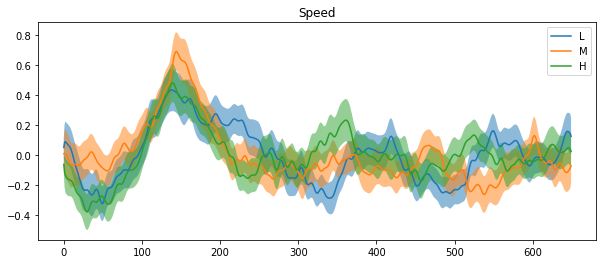

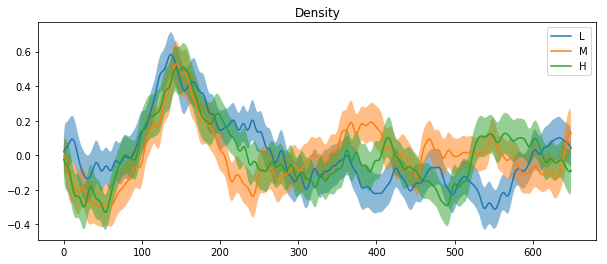

In [8]:
erps_speed = get_erps('speed')
plot_erps(erps_speed,title='Speed')

erps_density = get_erps('density')
plot_erps(erps_density,title='Density')